<a href="https://colab.research.google.com/github/lee021/2024-spark/blob/main/lee021/movie_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, year, datediff, expr, lit, when, sum
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import to_date

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [5]:
genreDf = spark.read.csv('movie_data/movie_genres.csv', header=True, sep=",")
genreDf = genreDf.dropDuplicates(["movieId", "genre"])
genreDf.show(10, truncate=False)
genreDf.printSchema()

+--------+-------+----------+
|mgenreId|movieId|genre     |
+--------+-------+----------+
|389     |1      |Animation |
|431     |1      |Children's|
|553     |1      |Comedy    |
|1223    |10     |Drama     |
|2796    |10     |War       |
|1070    |100    |Crime     |
|1264    |100    |Drama     |
|2568    |100    |Thriller  |
|855     |1000   |Comedy    |
|2887    |1000   |Western   |
+--------+-------+----------+
only showing top 10 rows

root
 |-- mgenreId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- genre: string (nullable = true)



In [6]:
ratingDf = spark.read.csv('movie_data/ratings.csv', header=True, sep=",")
ratingDf.show(5,truncate=False)
ratingDf.printSchema()

+--------+------+-------+------+----------------+
|ratingId|userId|movieId|rating|timestamp       |
+--------+------+-------+------+----------------+
|1       |196   |242    |3     |1997-12-04 15:55|
|2       |186   |302    |3     |1998-04-04 19:22|
|3       |22    |377    |1     |1997-11-07 7:18 |
|4       |244   |51     |2     |1997-11-27 5:02 |
|5       |166   |346    |1     |1998-02-02 5:33 |
+--------+------+-------+------+----------------+
only showing top 5 rows

root
 |-- ratingId: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [7]:
movieDf = spark.read.csv('movie_data/movie.csv', header=True, sep=",")
movieDf.show(5,truncate=False)
movieDf.printSchema()

+--------+-----------------+------------+------------------+------------------------------------------------------+
|movie id|movie title      |release date|video release date|IMDb URL                                              |
+--------+-----------------+------------+------------------+------------------------------------------------------+
|1       |Toy Story (1995) |01-Jan-95   |01-Jan-95         |http://us.imdb.com/M/title-exact?Toy%20Story%20(1995) |
|2       |GoldenEye (1995) |01-Jan-95   |01-Jan-95         |http://us.imdb.com/M/title-exact?GoldenEye%20(1995)   |
|3       |Four Rooms (1995)|01-Jan-95   |01-Jan-95         |http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|
|4       |Get Shorty (1995)|01-Jan-95   |01-Jan-95         |http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|
|5       |Copycat (1995)   |01-Jan-95   |01-Jan-95         |http://us.imdb.com/M/title-exact?Copycat%20(1995)     |
+--------+-----------------+------------+------------------+------------

In [8]:
userDf = spark.read.csv('movie_data/user.csv', header=True, sep=",")
userDf.show(5,truncate=False)
userDf.printSchema()

+------+---+------+----------+--------+
|userid|age|gender|occupation|zip code|
+------+---+------+----------+--------+
|1     |24 |M     |technician|85711   |
|2     |53 |F     |other     |94043   |
|3     |23 |M     |writer    |32067   |
|4     |24 |M     |technician|43537   |
|5     |33 |F     |other     |15213   |
+------+---+------+----------+--------+
only showing top 5 rows

root
 |-- userid: string (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- zip code: string (nullable = true)



**과제 1**

In [52]:
userDf = userDf.filter((col('gender')=='F') & (col('age')<=30) & (col('age') >=20))


# user.csv에서 해당 연령, 성별에 일치하는 user_id 추출
get_userid_Df = userDf.select(col('userid'))
join_condition_1 = (ratingDf.userId == get_userid_Df.userid)
matched_rows = ratingDf.join(get_userid_Df, join_condition_1, 'inner')\
.select(ratingDf["*"]).drop("timestamp").drop('ratingId')
# .select(ratingsDf["*"]): 원본 DataFrame의 모든 열을 선택하여 새로운 DataFrame을 생성


# movie_genres.csv에서 movieid의 genre들을 추출
join_condition_2 = (matched_rows.movieId==genreDf.movieId)
matched_rows = genreDf.join(matched_rows, join_condition_2, 'inner')\
.drop("mgenreId").drop("userId").drop("movieId")


# 최종 그룹화
matched_rows = matched_rows.groupBy('genre').agg(
    count('genre').alias('count'),
    avg('rating').alias('averageRating')
)

# 오름차순 정렬
matched_rows = matched_rows.orderBy(col('averageRating').desc(), col('count').desc())
matched_rows.show()

+-----------+-----+------------------+
|      genre|count|     averageRating|
+-----------+-----+------------------+
|        War|  850|3.6941176470588237|
|    Romance| 2439|3.5953259532595325|
|    Musical|  638|3.5940438871473352|
|  Film-Noir|  134| 3.582089552238806|
|      Drama| 4392| 3.566256830601093|
|  Animation|  497| 3.545271629778672|
|      Crime|  776| 3.506443298969072|
|Documentary|   69| 3.463768115942029|
|    Mystery|  489|3.4519427402862988|
|  Adventure| 1402| 3.412981455064194|
|   Thriller| 2232|3.4094982078853047|
|     Sci-Fi| 1204|3.3903654485049834|
| Children's| 1019| 3.379784102060844|
|     Action| 2452| 3.372756933115824|
|     Comedy| 3523|3.3624751632131704|
|    Western|  156| 3.217948717948718|
|     Horror|  571|3.1453590192644483|
|    Fantasy|  165|3.0424242424242425|
|    unknown|    1|               3.0|
+-----------+-----+------------------+



**과제 2**

In [57]:
ratingDf = spark.read.csv('movie_data/ratings.csv', header=True, sep=",")
genreDf = spark.read.csv('movie_data/movie_genres.csv', header=True, sep=",")
genreDf = genreDf.dropDuplicates(["movieId", "genre"])

# movieId의 평균 평점을 계산한 dataFrame 생성
average_ratings = ratingDf.groupBy('movieId').agg(
    avg('rating').alias('averageRating')
).orderBy(col('movieId'))

# genreDf를 movieId 기준으로 join
# average_ratings에 genreDf를 join해볼까
join_condition = (average_ratings.movieId == genreDf.movieId)
average_ratings = average_ratings.join(genreDf, join_condition, 'inner').drop('mgenreId').drop('movieId')


# genre를 기준으로 averageRating이 4.0이상인 영화의 갯수, 2.0 이하인 영화의 갯수를 각각 열로 한 dataFrame을 만들자.
average_ratings = average_ratings.groupBy('genre').agg(
    count(when(col('averageRating') >= 4.0, True)).alias('highRatedCount'),
    count(when(col('averageRating') < 2.0, True)).alias('lowRatedCount')
).orderBy(col('highRatedCount').desc())

average_ratings.show(100)


# 내 상황 : lowRatedCount가 성온님의 것과 비교해봤을 때 전체적으로 높게 분포. => 영화의 수가 더 많음.
# => 추측 1 : join 과정에서 중복 발생
# => 추측 2 : when 사용 미숙?


+-----------+--------------+-------------+
|      genre|highRatedCount|lowRatedCount|
+-----------+--------------+-------------+
|      Drama|            84|           49|
|     Comedy|            36|           37|
|   Thriller|            33|           13|
|    Romance|            27|            9|
|        War|            20|            1|
|      Crime|            17|            2|
|     Action|            16|           18|
|  Adventure|            15|            4|
|    Mystery|            14|            2|
|Documentary|            12|            6|
|  Film-Noir|            12|            1|
|     Sci-Fi|             8|            5|
|  Animation|             5|            2|
|    Musical|             3|            1|
|     Horror|             3|           13|
| Children's|             2|            8|
|    Western|             2|            2|
|    Fantasy|             1|            3|
|    unknown|             0|            1|
+-----------+--------------+-------------+



**과제 3**

In [58]:
activity_df = ratingDf.groupBy('userId').agg(
    count('rating').alias('ratingCount'),
    avg('rating').alias('averageRating')
).orderBy(col('ratingCount').desc())
activity_df.show(10)



+------+-----------+------------------+
|userId|ratingCount|     averageRating|
+------+-----------+------------------+
|   405|        737|1.8344640434192674|
|   655|        685| 2.908029197080292|
|    13|        636|  3.09748427672956|
|   450|        540|3.8648148148148147|
|   276|        518| 3.465250965250965|
|   416|        493| 3.845841784989858|
|   537|        490|2.8653061224489798|
|   303|        484| 3.365702479338843|
|   234|        480| 3.122916666666667|
|   393|        448|3.3370535714285716|
+------+-----------+------------------+
only showing top 10 rows



**분석 4**

In [54]:
Action_Df = genreDf.filter((col('genre')=='Action')).drop('mgenreId')
ratingDf = spark.read.csv('movie_data/ratings.csv', header=True, sep=",")
userDf = spark.read.csv('movie_data/user.csv', header=True, sep=",")

# userId 추출
join_condition_1 = (Action_Df.movieId == ratingDf.movieId)
Action_Df = ratingDf.join(Action_Df, join_condition_1, 'inner').drop('ratingId').drop('timestamp')\
.drop('movieId')


# age 추출
join_condition_2 = (Action_Df.userId == userDf.userid)
Action_Df = userDf.join(Action_Df, join_condition_2, 'inner').drop('userid').drop('gender')\
.drop('occupation').drop('zip code').orderBy(col('age').asc())


# 나잇대 별로(10대, 20대, 30대..) 평균 평점을 구해서, 연령순으로 정렬해야겠다.
Action_Df = Action_Df.groupBy('age').agg(
    avg('rating').alias('averageRating')
).orderBy(col('age').cast('int').asc())

Action_Df.show(10)


+---+------------------+
|age|     averageRating|
+---+------------------+
|  7| 3.611111111111111|
| 10|               4.0|
| 11| 3.076923076923077|
| 13|3.4934210526315788|
| 14| 3.593220338983051|
| 15|               3.5|
| 16|3.5217391304347827|
| 17| 3.651006711409396|
| 18|3.7417677642980935|
| 19| 3.307101727447217|
+---+------------------+
only showing top 10 rows



## **분석 5 : 개봉 시기와 관객 수의 관계**
문제 설명 : 사용자(관객)들이 가장 선호하는 영화 개봉 시기를 분석하시오. (ratings 1번 당 관람 1회로 가정)

1.   movie, ratings 테이블을 사용합니다.
2.   각 영화의 release date(개봉날짜)를 4분기로 구분합니다.
3. 각 영화의 ratings 수를 계산하고, 분기별로 분포를 냅니다.
4. ratings(관객수로 가정) 수가 많은 순서대로 정렬시켜, 결과를 확인합니다.



In [9]:
# 분석 전 예상 : 연초, 연말에 안 보던 사람들도 영화를 보러 가지 않을까?

movieDf = spark.read.csv('movie_data/movie.csv', header=True, sep=",")
movieDf = movieDf.drop("movie title").drop("video release date").drop("iMDb URL")
ratingDf = spark.read.csv('movie_data/ratings.csv', header=True, sep=",")

# 각 영화의 rating 수를 분석
ratingDf = ratingDf.groupBy('movieId').agg(
    count('rating').alias('watching_Count')
).orderBy(col('movieId').cast('int').asc())

# ratingDf.show(10)

# 분기별로 영화를 나눠보자.
# release date에 Jan, Feb, Mar 중 하나가 포함돼 있으면 quater열의 값을 1,
# Apr, May, Jun 중 하나가 포함돼 있으면 quater열의 값을 2,
# Jul, Aug, Sep 중 하나가 포함돼 있으면 quater열의 값을 3,
# Oct, Nov, Dec 중 하나가 포함돼 있으면 quater열의 값을 4로 갖는 dataFame을 생성해야겠음.

# udf 사용해서 최적화하기 ☆☆☆☆
# getMonth 활용 (date)
movieDf = movieDf.withColumn("quater", when(col("release date").contains("Jan"), 1)\
                             .when(col("release date").contains("Feb"), 1)\
                             .when(col("release date").contains("Mar"), 1)\
                             .when(col("release date").contains("Apr"), 2)\
                             .when(col("release date").contains("May"), 2)\
                             .when(col("release date").contains("Jun"), 2)\
                             .when(col("release date").contains("Jul"), 3)\
                             .when(col("release date").contains("Aug"), 3)\
                             .when(col("release date").contains("Sep"), 3)\
                             .when(col("release date").contains("Oct"), 4)\
                             .when(col("release date").contains("Nov"), 4)\
                             .when(col("release date").contains("Dec"), 4)\
                             .otherwise(None))



# movieDf.show(10)

# ratingDf 와 movieDf를 movieId로 inner join한다.
movieDf = movieDf.withColumnRenamed('movie id', 'movieId')

join_condition = (ratingDf.movieId == movieDf.movieId)
movieDf = movieDf.join(ratingDf, join_condition, 'inner').drop('movieId')
# movieDf


movieDf = movieDf.withColumn('watching_Count', col('watching_Count').cast('int'))


movieDf = movieDf.groupBy('quater').agg(
    sum('watching_Count').alias('watching_Count')
).orderBy(col('watching_Count').desc())

movieDf = movieDf.filter(movieDf.watching_Count != 9) # 꼼수 : NULL은 왜 삭제가 안되나?

# 원래 의도한 문장
# movieDf = movieDf.filter(movieDf.quater != NULL)

movieDf.show()


# 결론 : 사람들은 연초와 연말에 영화를 많이 본다. 예상과 일치!


+------+--------------+
|quater|watching_Count|
+------+--------------+
|     1|         78165|
|     4|          7477|
|     2|          7410|
|     3|          6939|
+------+--------------+



분석 6

**특정 직업군의 영화 선호도 분석**

문제 설명 : 직업군 별로 높게 평가한 장르와, 낮게 평가한 장르를 분석하십시오

( 높게 평가 : 평균 4.0이상,   낮게 평가 : 평균 2.0 이하 )

1.   movie_genres, ratings, user 테이블을 사용합니다.
2.   

예시 :

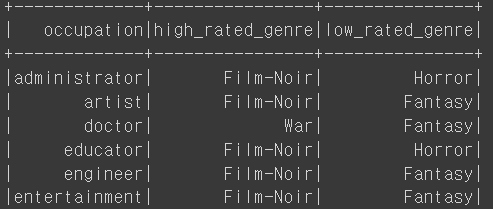



In [60]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

ratingDf = spark.read.csv('movie_data/ratings.csv', header=True, sep=",")
userDf = spark.read.csv('movie_data/user.csv', header=True, sep=",")
genreDf = spark.read.csv('movie_data/movie_genres.csv', header=True, sep=",")
genreDf = genreDf.dropDuplicates(["movieId", "genre"])

ratingDf = ratingDf.drop("ratingId").drop("timestamp")
genreDf = genreDf.drop("mgenreId")
userDf = userDf.drop("zip code").drop("age").drop("gender")

# ratingDf.show()
# genreDf.show()
# userDf.show()

# ratingDf에 userId를 기준으로 userDf를 inner join

join_condition_1 = (ratingDf.userId == userDf.userid)
ratingDf = userDf.join(ratingDf, join_condition_1, 'inner').drop('userid')
# ratingDf.show()

# ratingDf에 movieId를 기준으로 genreDf를 inner join
join_condition_2 = (ratingDf.movieId == genreDf.movieId)
ratingDf = genreDf.join(ratingDf, join_condition_2, 'inner').drop('movieId')


# 각 장르의 평균 평점을 계산
genre_ratings = ratingDf.groupBy("occupation", "genre").agg(
    avg("rating").alias("averageRating")
).orderBy("occupation")

genre_ratings = genre_ratings.filter(genre_ratings.genre != "unknown")

# genre_ratings.show(100)




# WindowSpec 정의 (occupation별로 partition)
# partitionBy : (데이터를) 그룹화할 열 지정
# orderBy : (데이터를)정렬할 열 지정
windowSpec = Window.partitionBy("occupation").orderBy(col("averageRating").desc())

# row_number를 사용하여 가장 높은 평점과 가장 낮은 평점 순위를 매김
# 행에 순위(번호)를 매김 (1로 매겨짐). => 각 직업별로 높은 평점, 낮은 평점 받은 장르를 구분 가능.
genre_ratings_with_rank = genre_ratings.withColumn("rank_high", row_number().over(windowSpec)) \
                                       .withColumn("rank_low", row_number().over(windowSpec.orderBy(col("averageRating").asc())))

# 가장 높은 평점을 받은 장르
high_rated_genre = genre_ratings_with_rank.filter(col("rank_high") == 1).select("occupation", col("genre").alias("high_rated_genre"))
high_rated_genre.show()

# 가장 낮은 평점을 받은 장르
low_rated_genre = genre_ratings_with_rank.filter(col("rank_low") == 1).select("occupation", col("genre").alias("low_rated_genre"))

# high_rated_genre와 low_rated_genre를 occupation을 기준으로 조인
result_df = high_rated_genre.join(low_rated_genre, on="occupation")

# 결과 출력
result_df.show()



+-------------+----------------+
|   occupation|high_rated_genre|
+-------------+----------------+
|administrator|       Film-Noir|
|       artist|       Film-Noir|
|       doctor|             War|
|     educator|       Film-Noir|
|     engineer|       Film-Noir|
|entertainment|       Film-Noir|
|    executive|             War|
|   healthcare|         Musical|
|    homemaker|         Mystery|
|       lawyer|       Film-Noir|
|    librarian|       Film-Noir|
|    marketing|       Film-Noir|
|         none|             War|
|        other|       Film-Noir|
|   programmer|             War|
|      retired|       Film-Noir|
|     salesman|     Documentary|
|    scientist|       Film-Noir|
|      student|       Film-Noir|
|   technician|       Film-Noir|
+-------------+----------------+
only showing top 20 rows

+-------------+----------------+---------------+
|   occupation|high_rated_genre|low_rated_genre|
+-------------+----------------+---------------+
|administrator|       Film-Noir|   

In [46]:
genreDf = spark.read.csv('movie_data/movie_genres.csv', header=True, sep=",")
genreDf = genreDf.dropDuplicates(["movieId", "genre"])

genreDf = genreDf.groupBy('genre').agg(
    count('genre').alias('count')
).orderBy(col('count').desc())


genreDf.show()

+-----------+-----+
|      genre|count|
+-----------+-----+
|      Drama|  725|
|     Comedy|  505|
|   Thriller|  251|
|     Action|  251|
|    Romance|  247|
|  Adventure|  135|
| Children's|  122|
|      Crime|  109|
|     Sci-Fi|  101|
|     Horror|   92|
|        War|   71|
|    Mystery|   61|
|    Musical|   56|
|Documentary|   50|
|  Animation|   42|
|    Western|   27|
|  Film-Noir|   24|
|    Fantasy|   22|
|    unknown|    2|
+-----------+-----+



In [27]:
from pyspark.sql.types import StructType, StructField
sc = spark.sparkContext
#Create empty df with header
schema_header = StructType([StructField("occupation", StringType(), True),
                            StructField("Action", StringType(), True),
                           StructField("Adventure", StringType(), True),
                           StructField("Animation", StringType(), True),
                           StructField("Children's", StringType(), True),
                           StructField("Comedy", StringType(), True),
                           StructField("Crime", StringType(), True),
                           StructField("Documentary", StringType(), True),
                           StructField("Drama", StringType(), True),
                           StructField("Fantasy", StringType(), True),
                           StructField("Film-Noir", StringType(), True),
                            StructField("Horror", StringType(), True),
                            StructField("Musical", StringType(), True),
                            StructField("Mystery", StringType(), True),
                            StructField("Romance", StringType(), True),
                            StructField("Sci-Fi", StringType(), True),
                            StructField("Thriller", StringType(), True),
                            StructField("War", StringType(), True),
                            StructField("Western", StringType(), True),
                            StructField("unknown", StringType(), True)])
empty_with_header = spark.createDataFrame(sc.emptyRDD(), schema_header)
empty_with_header.show()

+----------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+-------+
|occupation|Action|Adventure|Animation|Children's|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|Musical|Mystery|Romance|Sci-Fi|Thriller|War|Western|unknown|
+----------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+-------+
+----------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+-------+

